In [ ]:
import os
import re
import tqdm
import spacy
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import umap
from sklearn import (
    preprocessing, 
    decomposition, 
    discriminant_analysis, 
    manifold,
)
from matplotlib import (
    pyplot as plt, 
    lines,
    ticker,
)
import torch
import sentence_transformers

plt.style.use("theme.mplstyle")
warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

class SUBSETS:
    classic_psychedelics = ("LSD", "Psilocybin", "DMT", "5-MeO-DMT")
    psychoactives = ("MDMA", "LSD", "Psilocybin", "DMT", "5-MeO-DMT", "Ketamine", "Salvinorin A", "THC", "Cocaine")
    selection = ("MDMA", "LSD", "Psilocybin", "DMT", "Ketamine")

COLORMAP = {
    "5-MeO-DMT"         : "C0",
    "DMT"               : "C3",
    "LSD"               : "C2",
    "Psilocybin"        : "C1",

    "MDMA"              : "C4",
    "Ketamine"          : "deepskyblue",
    "Salvinorin A"      : "maroon",
    "Ibogaine"          : "yellow",

    "Alcohol"           : "purple",
    "THC"               : "forestgreen",
    "Cocaine"           : "deepskyblue",
    "Oxycodone"         : "saddlebrown",
    "Methamphetamine"   : "orange",
}

DIMENSION_KEY = dict(
    OBN = "Oceanic Boundlessness",
    AED = "Anxious Ego-Dissolution",
    VIR = "Visual Restructuralization",
)

substances = pd.read_csv("data/substances.csv", dtype = dict(pharmacological_class = "category", chemical_class = "category"), comment = "#")
substances["colloquialisms"] = substances["colloquialisms"].str.split(";")

In [2]:
if not "model" in globals():
    # model = sentence_transformers.SentenceTransformer("nvidia/NV-Embed-v2", trust_remote_code=True)
    # model.save("data/transformer_models/NV-Embed-v2.model")
    model = sentence_transformers.SentenceTransformer("data/transformer_models/NV-Embed-v2.model", trust_remote_code=True)

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

In [3]:
def load_data():
    global database
    if os.path.exists("data/database_preprocessed.parquet"):
        database = pd.read_parquet("data/database_preprocessed.parquet")
    else:
        database = pd.read_parquet("data/database.parquet")
        database = database[database["substance"].isin(substances["label"])]
        database["substance"] = pd.Categorical(database["substance"], categories = substances["label"], ordered = True)
        database["submission_timestamp"] = pd.to_datetime(database["time_of_submission"].str.strip(), format = "%b %d, %Y", errors = "coerce")
        database["experience_timestamp"] = pd.to_datetime(database["time_of_experience"].str.extract("(\d{4})", expand = False) , format = "%Y", errors = "coerce")
        database["years_since_experience"] = database["submission_timestamp"].dt.year - database["experience_timestamp"].dt.year
        database["age_at_experience"] = database["age_at_experience"].str.strip().replace({"Not Given": pd.NA})
        database["sex"] = database["gender"].replace({"not specified": pd.NA})
        database["content_raw"] = database["content"].fillna("").str.replace(r"<[^>]+>|\[Erowid Note:([\s\S]*)\]|\n|\r|<br>", " ", regex=True)
        database["content"] = database["content_raw"].str.replace("(\s?[, ]\s?)(" + "|".join([item for row in substances["colloquialisms"].values for item in row]) + ")(\s?[, ]\s?)", r"\1this\3", regex = True, flags = re.IGNORECASE)
        database = database[database["content"].str.strip() != ""]
        database["content_sanitized"] = database["content"].str.replace("""[^A-Za-z'"., -]+""", "", regex = True)
        database["author"], _ = pd.factorize(database["author"].apply(lambda val: pd.NA if val.lower() == "anonymous" else val), use_na_sentinel = True)
        database = database.reset_index(drop = True)[["experience_ID", "substance", "content", "content_sanitized", "experience_timestamp", "submission_timestamp", "years_since_experience", "author", "sex", "age_at_experience"]]
        database.to_parquet("data/database_preprocessed.parquet")

    database.info()
    # return database.sample(3)

load_data()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6912 entries, 0 to 6911
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   experience_ID           6912 non-null   object        
 1   substance               6912 non-null   category      
 2   content                 6912 non-null   object        
 3   content_sanitized       6912 non-null   object        
 4   experience_timestamp    6841 non-null   datetime64[ns]
 5   submission_timestamp    6912 non-null   datetime64[ns]
 6   years_since_experience  6841 non-null   float64       
 7   author                  6912 non-null   int64         
 8   sex                     6478 non-null   object        
 9   age_at_experience       2110 non-null   object        
dtypes: category(1), datetime64[ns](2), float64(1), int64(1), object(5)
memory usage: 493.3+ KB


In [4]:
def load_processed_data(subset = None):
    global database
    database = pd.read_parquet("data/database_preprocessed.parquet")
    database["substance"] = pd.Categorical(database["substance"], categories = substances["label"], ordered = True)
    database["embedding"] = np.load("data/embeddings_full.npy").tolist()

    database = database[database["content"].str.split().str.len() > 100]

    if subset:
        database = database[database["substance"].isin(subset)]
    database = database.reset_index(drop = True)

    database.info()
    # database.to_parquet("data/database_processed.parquet")
    # return database.sample(3)

load_processed_data()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6864 entries, 0 to 6863
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   experience_ID           6864 non-null   object        
 1   substance               6864 non-null   category      
 2   content                 6864 non-null   object        
 3   content_sanitized       6864 non-null   object        
 4   experience_timestamp    6793 non-null   datetime64[ns]
 5   submission_timestamp    6864 non-null   datetime64[ns]
 6   years_since_experience  6793 non-null   float64       
 7   author                  6864 non-null   int64         
 8   sex                     6438 non-null   object        
 9   age_at_experience       2095 non-null   object        
 10  embedding               6864 non-null   object        
dtypes: category(1), datetime64[ns](2), float64(1), int64(1), object(6)
memory usage: 543.5+ KB


In [5]:
def print_descriptive_statistics(substance_subset = None):
    data = database[database["substance"].isin(substance_subset)] if substance_subset else database

    print(len(data), "reports across", data["substance"].nunique(), "compounds")
    print(data["author"].nunique(), "unique contributors,", "{:.1%}".format(data[~data["sex"].isna()].drop_duplicates("author")["sex"].eq("female").mean()), "of which are female and", (data["author"] == -1).sum(), "of which were anonymous")
    print()
    print(data["substance"].cat.remove_unused_categories().value_counts(dropna = False).rename("reports").to_frame().transpose())
    print()
    print(data[data["author"] != -1].groupby("author").size().agg(("min", "max", "median", "mean", "std")).round(3).to_frame("reports per author").transpose())
    print()
    print(data[data["author"] != -1].groupby("substance", observed = True)["author"].value_counts().groupby("substance").agg(("median", "mean", "min", "max")))
    print()
    print((data.groupby("substance", observed = True)["sex"].value_counts() / data.groupby("substance", observed = True)["sex"].value_counts().groupby("substance").sum()).round(2))
    print()
    print(data["content"].str.split().str.len().agg(("min", "max", "median", "mean", "std")).round(0).astype(int).rename("words").to_frame().transpose())
    print()
    print("{:_d}".format(data["content"].str.split().str.len().sum().round(1)), "words in total comprise the corpus")
    print()
    data["n_words"] = data["content"].str.split().str.len()
    print(data.groupby("substance", observed = True)["n_words"].agg(("sum", "median", "mean", "min", "max")).round())
    print()
    data["age_at_experience"] = pd.to_numeric(data["age_at_experience"])
    print(data.groupby("substance", observed = True)["age_at_experience"].agg(("median", "mean", "min", "max")).round(1))
    print()
    print("submissions across years", "-".join(np.sort(data["submission_timestamp"].dt.year.agg(("min", "max")).astype(int).astype(str))))
    print()

print_descriptive_statistics(substance_subset = SUBSETS.selection)

3817 reports across 5 compounds
3407 unique contributors, 22.0% of which are female and 58 of which were anonymous

          LSD  Psilocybin  DMT  MDMA  Ketamine
reports  1172        1102  629   571       343



                    min   max  median   mean    std
reports per author  1.0  12.0     1.0  1.104  0.547

            median      mean  min  max
substance                             
DMT            1.0  1.040609    1    6
Psilocybin     1.0  1.059109    1   11
LSD            1.0  1.050412    1    4
Ketamine       1.0  1.021084    1    2
MDMA           1.0  1.038532    1    3

substance   sex   
DMT         male      0.88
            female    0.12
Psilocybin  male      0.77
            female    0.23
LSD         male      0.80
            female    0.20
Ketamine    male      0.86
            female    0.14
MDMA        male      0.63
            female    0.37
Name: sex, dtype: float64

       min    max  median  mean   std
words  101  24332     895  1170  1149

4_466_552 words in total comprise the corpus

                sum  median    mean  min    max
substance                                      
DMT          654127   818.0  1040.0  113   6464
Psilocybin  1365210   968.0  1239.0  1

/tmp/ipykernel_2940/3000213555.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["n_words"] = data["content"].str.split().str.len()
/tmp/ipykernel_2940/3000213555.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["age_at_experience"] = pd.to_numeric(data["age_at_experience"])


In [6]:
def run_pipeline():
    global database, docs
    load_data()
    database = database.sample(200)

    base_model = "en_core_web_trf"
    pipeline = spacy.load(base_model, disable = ["tagger", "parser", "attribute_ruler", "ner"])
    pipeline.add_pipe("sentencizer")

    print(pipeline.pipe_names)

    docs = list(tqdm.tqdm(pipeline.pipe(database["content"]), total = len(database)))
    if "transformer" in pipeline.pipe_names: 
        database["embedding"] = [doc._.trf_data.all_outputs[0].data[0] for doc in docs]
    else:
        database["embedding"] = [doc.vector for doc in docs]

    database.to_parquet("data/database_processed.parquet")
    return docs

# docs = run_pipeline()

In [ ]:
def compute_phenomenological_dimension_similarity():
    global database, query_embeddings, phenomenological_dimensions
    phenomenological_dimensions = {
        "OBN": "I experienced an all-embracing love. It seemed to me that my environment and I were one. I experienced a touch of eternity. I experienced a profound peace in myself. Conflicts and contradictions seemed to dissolve. Everything seemed to unify into oneness. I felt totally free and released from all responsibilities. Everything around me seemed animated. Worries and anxieties of everyday life seemed unimportant to me. I enjoyed boundless pleasure. My experience had religious aspects. I felt unusual powers in myself. I experienced past, present, and future as oneness. I had the feeling of being connected to a superior power. Many things appeared to be breathtakingly beautiful. The world appeared to me beyond good and evil. I experienced a kind of awe. The boundaries between myself and my surroundings seemed to blur. I felt as though I were floating. I felt like I was in a fantastic other world. I felt I was being transformed forever in a marvelous way. I gained clarity into connections that puzzled me before. I felt very profound. It seemed to me as though I did not have a body anymore. I had the feeling of being outside of my body.",
        "AED": "I felt threatened. I was afraid without being able to say exactly why. I experienced my surroundings as strange and weird. I was afraid to lose my self-control. I experienced everything terrifyingly distorted. I had the feeling something horrible would happen. I felt tormented. I was afraid that the state I was in would last forever. I felt as though I were paralyzed. I felt like a marionette. I had the feeling that I no longer had a will of my own. I felt isolated from everything and everyone. My body seemed to me numb, dead, and weird. I felt surrendered to dark powers. I had difficulty making even the smallest decision. I experienced an unbearable emptiness. Time passed tormentingly slow. I had difficulty in distinguishing important from unimportant things. Everything around me was happening so fast that I no longer could follow what was going on. I stayed frozen in a very unnatural position for quite a long time. I was not able to complete a thought, my thought repeatedly became disconnected.",
        "VIR": "I saw colors before me in total darkness or with closed eyes. I saw regular patterns in complete darkness or with closed eyes. The shapes of things seemed to change by sounds and noises. The colors of things seemed to be changed by sounds and noises. I saw scenes rolling by in total darkness or with my eyes closed. Noises seemed to influence what I saw. I saw lights or flashes of light in total darkness or with closed eyes. I saw things that I knew were not real. I could see pictures from my past or fantasy extremely clearly. My imagination was extremely vivid. Many things seemed unbelievably funny to me."
    }

    if not "query_embeddings" in globals():
        query_embeddings = model.encode(
        list(phenomenological_dimensions.values()),
        convert_to_numpy = True,
        normalize_embeddings = True,
        )

    similarities = model.similarity(
        query_embeddings.tolist(),
        database["embedding"].values.tolist(), 
    )

    phenomenological_dimensions = list(phenomenological_dimensions.keys())
    database[phenomenological_dimensions] = similarities.T

    database.info()

compute_phenomenological_dimension_similarity()
database[["substance", "author", "sex", "years_since_experience", "age_at_experience"] + phenomenological_dimensions].to_csv("data/database_processed.csv", index = False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6864 entries, 0 to 6863
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   experience_ID           6864 non-null   object        
 1   substance               6864 non-null   category      
 2   content                 6864 non-null   object        
 3   content_sanitized       6864 non-null   object        
 4   experience_timestamp    6793 non-null   datetime64[ns]
 5   submission_timestamp    6864 non-null   datetime64[ns]
 6   years_since_experience  6793 non-null   float64       
 7   author                  6864 non-null   int64         
 8   sex                     6438 non-null   object        
 9   age_at_experience       2095 non-null   object        
 10  embedding               6864 non-null   object        
 11  OBN                     6864 non-null   float32       
 12  AED                     6864 non-null   float32 

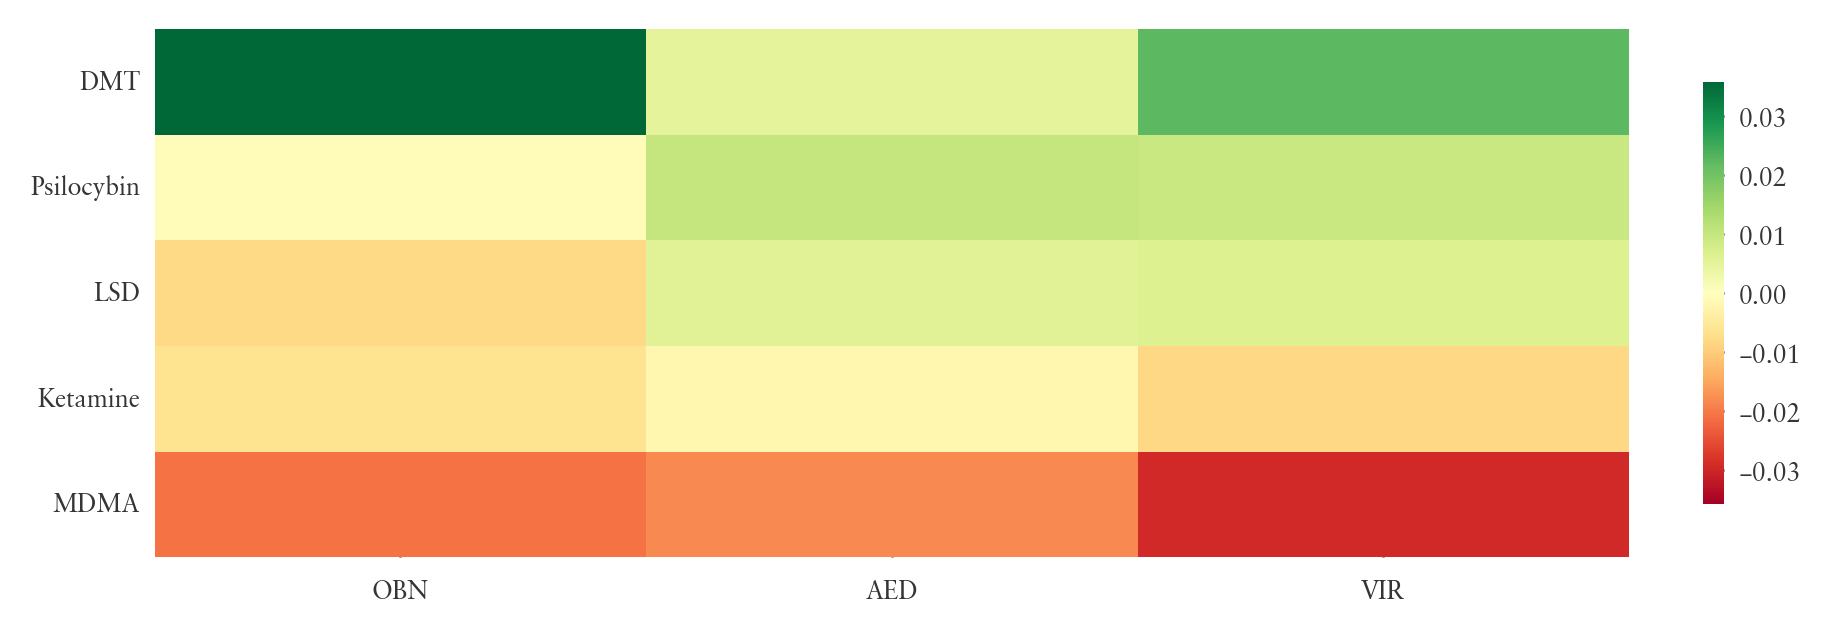

In [8]:
def heatmap(substance_subset = None, dimensions_subset = None, export = False):
    data = database[database["substance"].isin(substance_subset)] if substance_subset else database
    dimensions = dimensions_subset if dimensions_subset else phenomenological_dimensions

    # for dim in phenomenological_dimensions:
        # data[dim] = stats.zscore(data[dim], ddof = 1)

    heatmap = data.groupby("substance", observed = True)[dimensions].agg("mean")
    # heatmap = heatmap.sub(heatmap.mean(axis = 1), axis = 0)
    heatmap -= heatmap.mean()
    # heatmap = heatmap[heatmap.std().sort_values(ascending=False).index]

    plt.figure(figsize=(6, 2))
    sns.heatmap(
        heatmap,
        cmap = "RdYlGn",
        vmin = -heatmap.abs().max().max(),
        vmax = heatmap.abs().max().max(),
        cbar_kws = dict(shrink = 0.8, extend = "neither"),
    )
    # plt.xticks(rotation = 33, size = 5, ha = "right")
    plt.tick_params(axis="x", pad=5)
    plt.yticks(rotation = 0)

    plt.ylabel("")
    if export:
        plt.savefig(f"assets/dimensions_heatmap.png")
    plt.show()

heatmap(
    substance_subset=SUBSETS.selection,
)

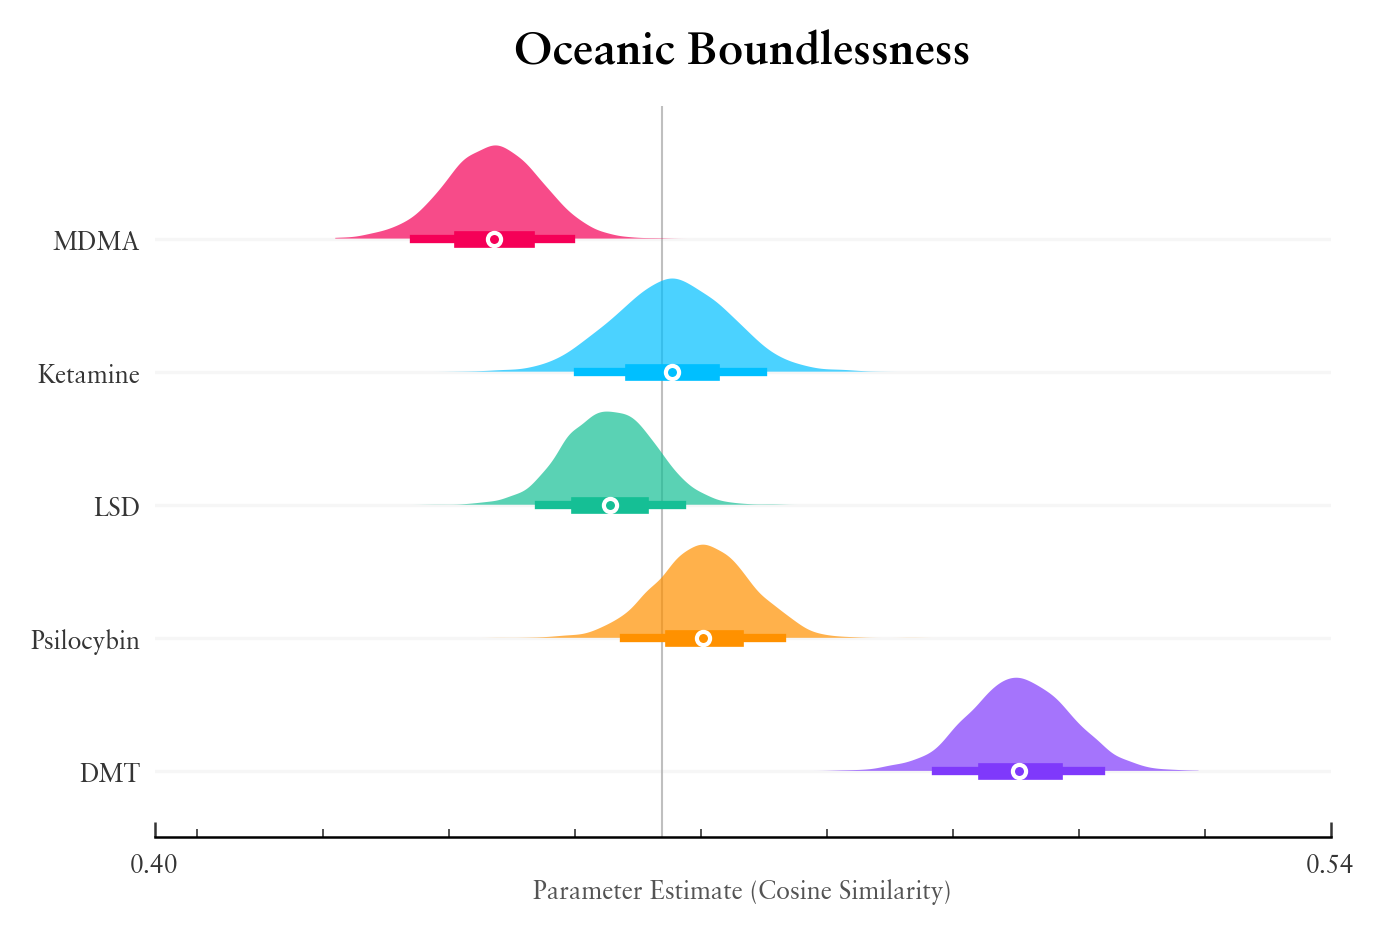

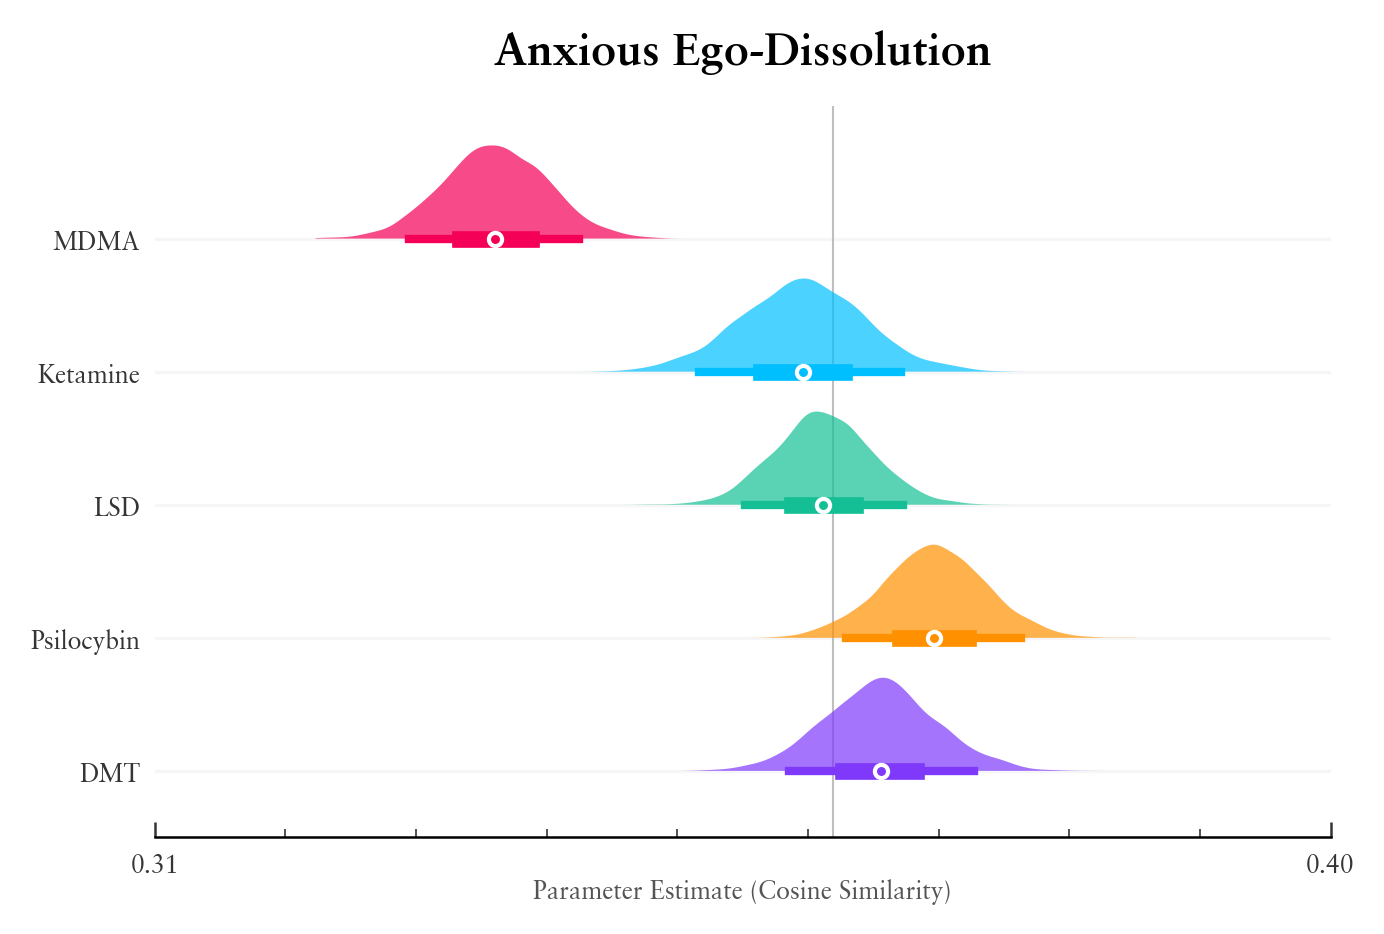

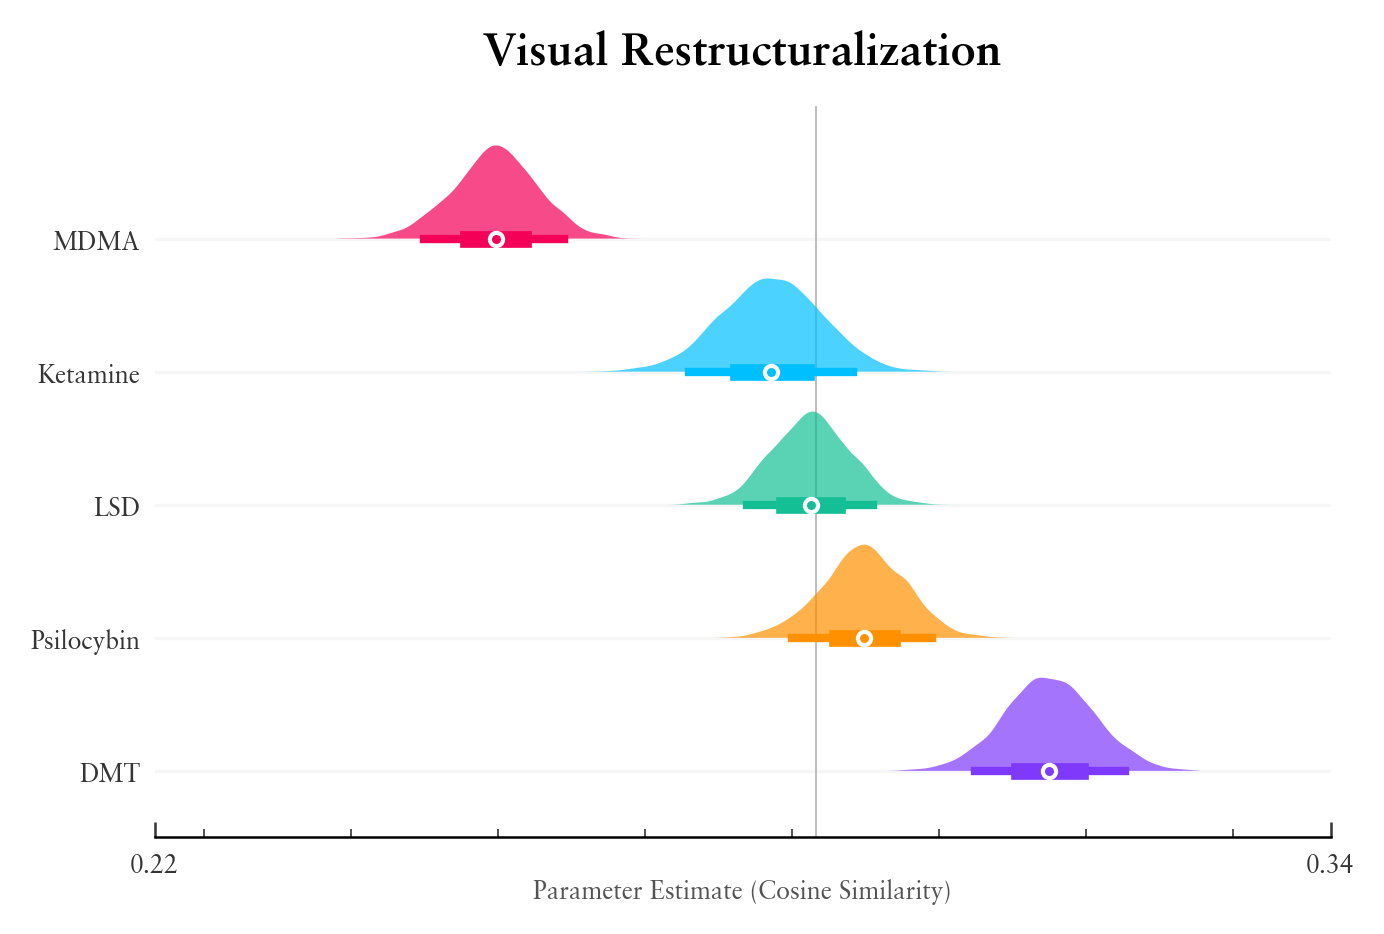

In [9]:
def compare_substances(export = False):
    model_fit = pd.read_csv("data/model_fit.csv")
    model_fit["substance"] = pd.Categorical(model_fit["substance"], categories = substances["label"], ordered = True)

    for dimension in phenomenological_dimensions:
        data = model_fit[model_fit["dimension"] == dimension]
        data_range = np.linspace(*data["sample"].agg(("min", "max")), num = 1000)

        plt.figure(figsize = (4.5, 3))

        for substance_idx, (substance, subset) in enumerate(data.groupby("substance", observed = True)["sample"]):
            estimation = stats.gaussian_kde(subset, bw_method = 0.2)(data_range)
            plt.fill_between(
                data_range, 
                substance_idx,
                substance_idx + 0.7 * (estimation / estimation.max()),
                color = COLORMAP[substance],
                label = substance,
                alpha = 0.7,
                edgecolor = "none",
                zorder = 1,
            )

            for interval, linewidth in zip((0.5, 0.9), (4, 2)):
                plt.plot(
                    np.quantile(subset, ((1 - interval) / 2, 1 - (1 - interval) / 2)),
                    [substance_idx, substance_idx],
                    linewidth = linewidth,
                    color = COLORMAP[substance],
                    # color = "black",
                )
            plt.scatter(
                [np.median(subset)],
                [substance_idx],
                facecolor = COLORMAP[substance],
                edgecolor = "white",
                marker = "o",
                s = 10,
                zorder = 2,
            )

        plt.axvline(data["sample"].median(), linewidth = 0.5, color = "grey", alpha = 0.5, zorder = -3)

        plt.yticks(np.arange(data["substance"].nunique()), data["substance"].sort_values().unique())
        plt.tick_params(left = False)
        plt.ylim(bottom = -0.5, top = data["substance"].nunique())
        plt.margins(x = 0.1)
        plt.xticks((plt.gca().get_xticks()[0], plt.gca().get_xticks()[-1]))
        plt.gca().xaxis.set_minor_locator(ticker.MaxNLocator(nbins = 10, steps = (1, 1.5, 5, 10), min_n_ticks = 3))
        plt.xlabel("Parameter Estimate (Cosine Similarity)", labelpad = 0)
        plt.ylabel("", labelpad = 0)
        plt.title(DIMENSION_KEY.get(dimension))
        plt.gca().spines["left"].set_visible(False)
        if export:
            plt.savefig(f"assets/{dimension}_fit.png")
        plt.show()

compare_substances(
    export = True,
)

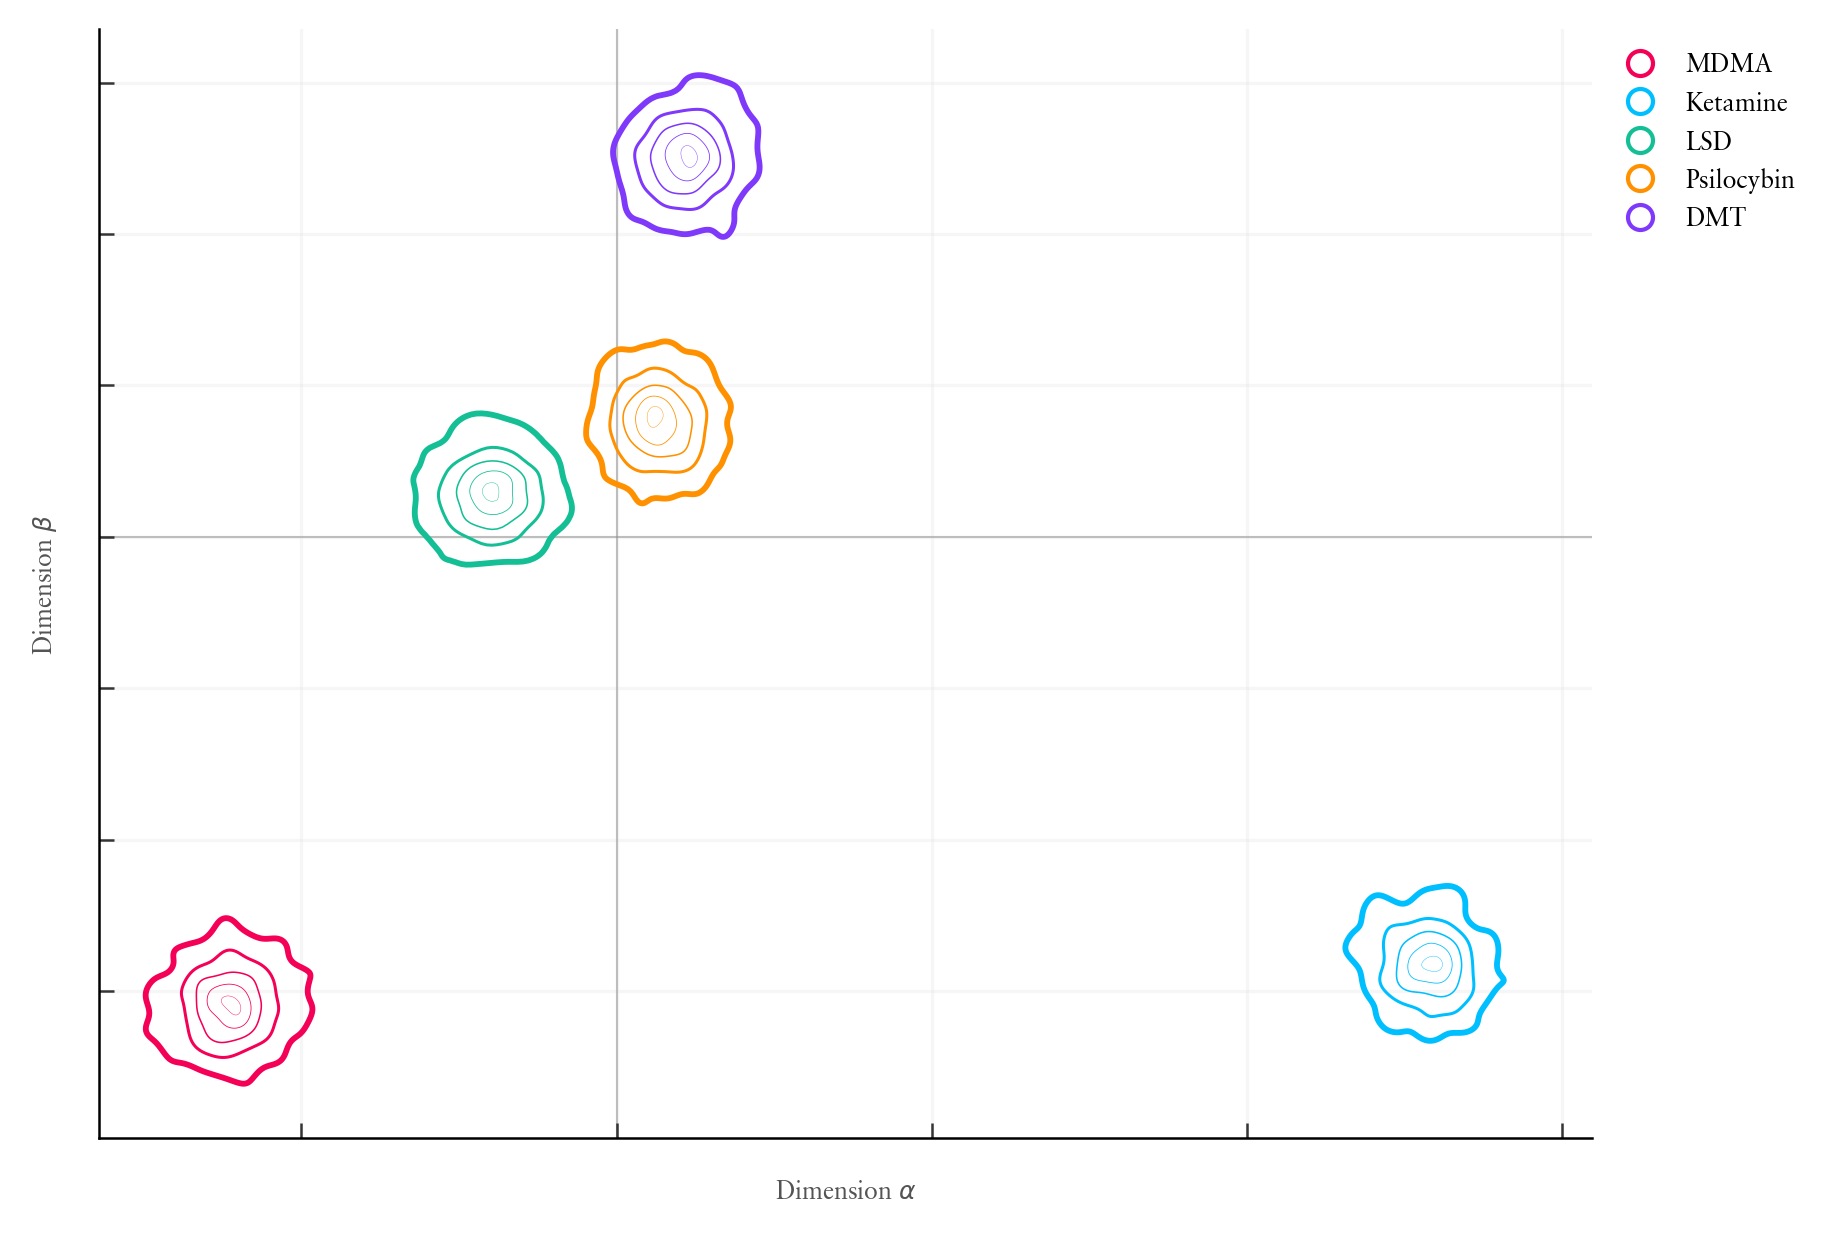

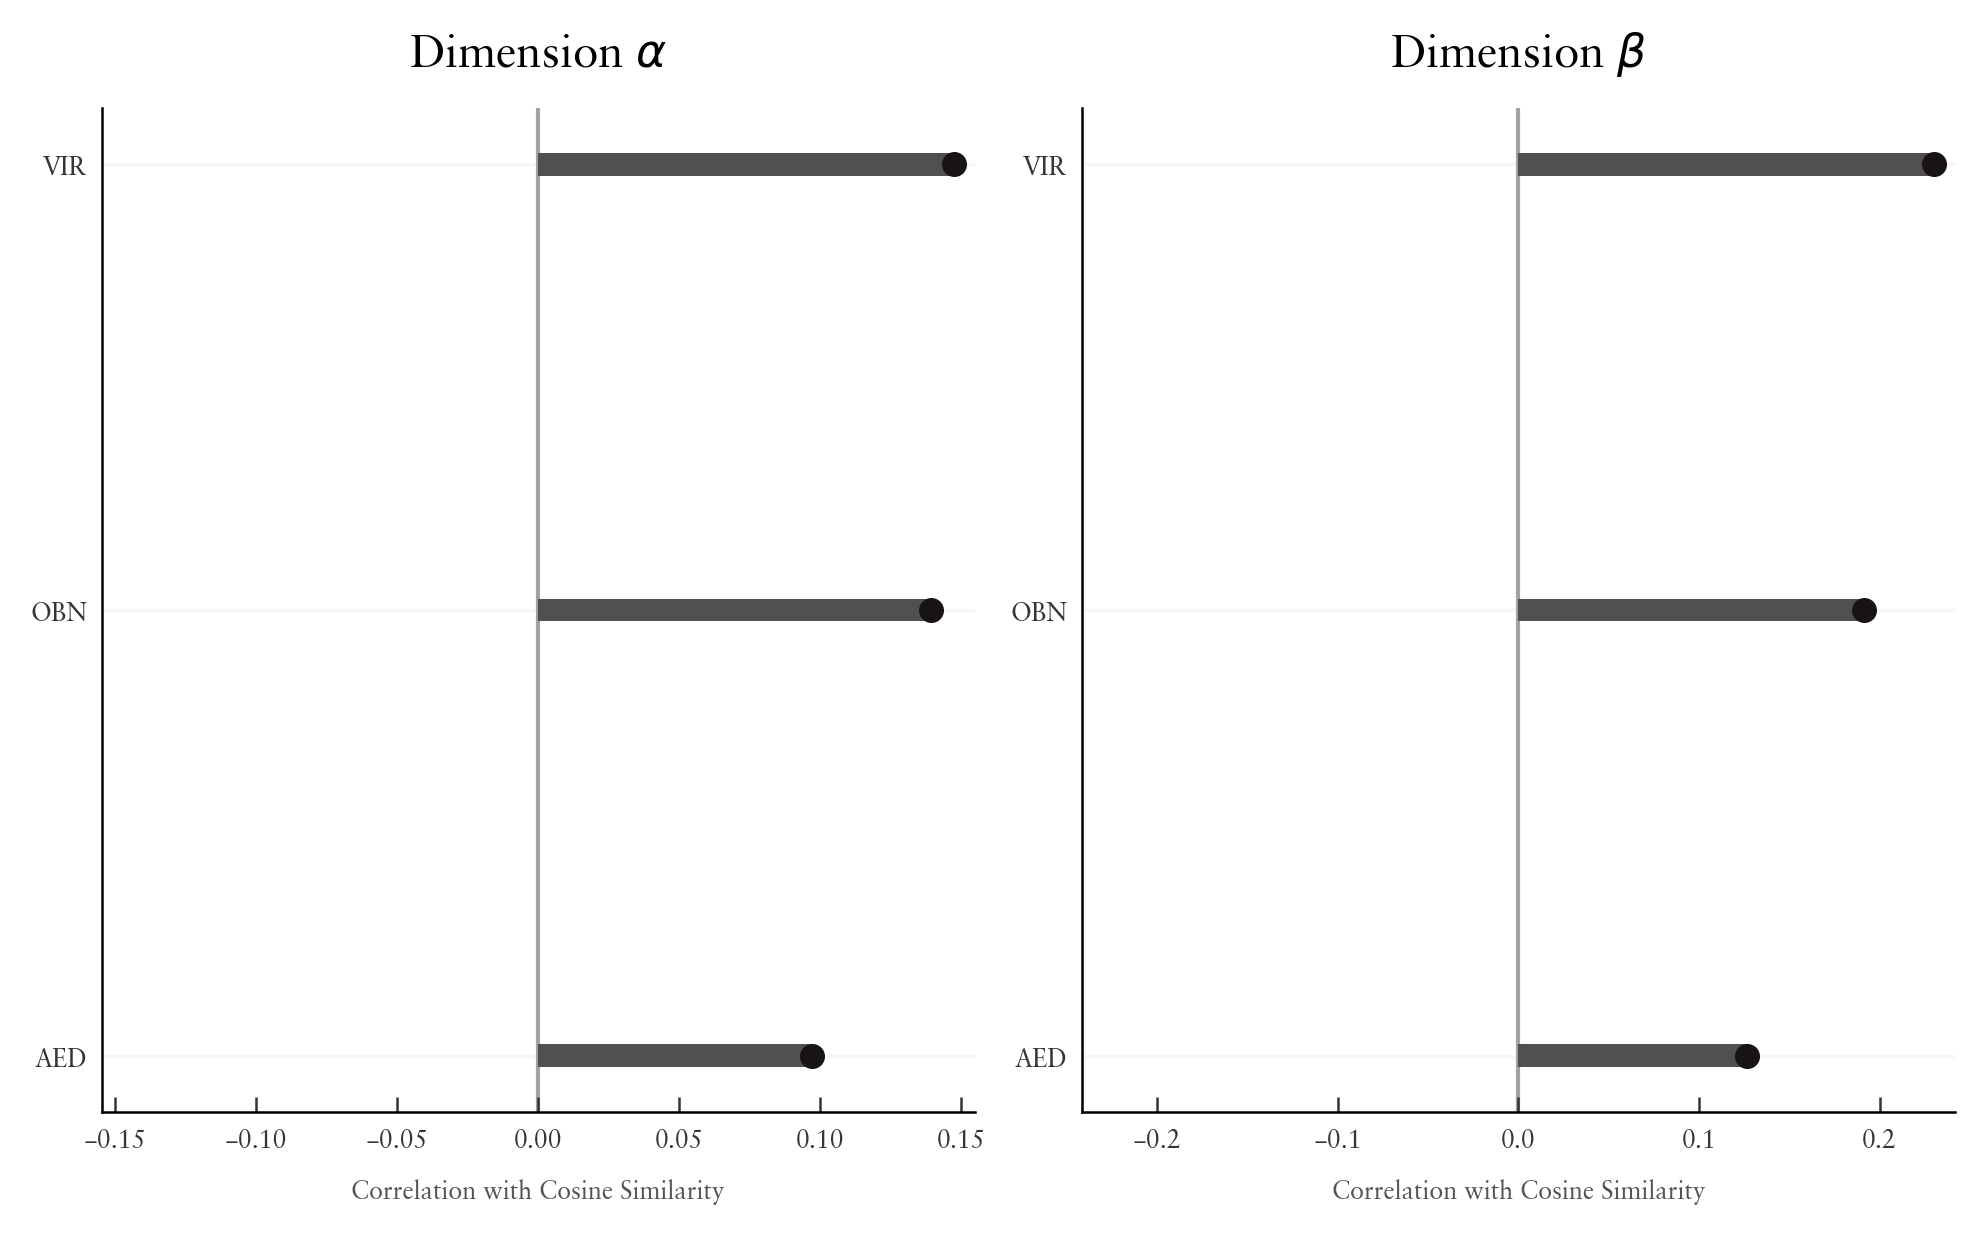

In [10]:
# load_processed_data()

def decompose(
    n_components = 2, 
    method = "LDA", 
    substance_subset = None, 
    show_scatter = False, 
    show_loadings = False, 
    export = False, 
    contours = None,
):
    data = database[database["substance"].isin(substance_subset)] if substance_subset else database
    data = data.sample(frac = 1) 
    data = data.dropna(subset = "substance")

    decomposer = dict(
        LDA = discriminant_analysis.LinearDiscriminantAnalysis, 
        PCA = decomposition.PCA,
        ICA = decomposition.FastICA,
        tSNE = manifold.TSNE,
        UMAP = umap.UMAP,
    )[method]
    
    data[[f"comp_{idx}" for idx in range(n_components)]] = decomposer(n_components=n_components).fit_transform(
        X = data["embedding"].tolist(),
        y = data["substance"].cat.codes, # ground truth labels, ignored for non-supervised algorithms
    )

    if show_scatter:
        fig, ax = plt.subplots(figsize=(6, 4))

        ax.scatter(
            data["comp_0"], 
            data["comp_1"], 
            color = "white",
            edgecolor = data["substance"].map(COLORMAP),
            s = 5,
            alpha = 0.6,
            clip_on = False,
        )

        ax.legend(
            handles = [lines.Line2D([], [], marker="o", color="w", label=substance, markeredgecolor=COLORMAP.get(substance), markersize=3) for substance in data["substance"].sort_values(ascending = False).unique()],
            loc = "upper left", 
            bbox_to_anchor = (1, 1), 
        )

        ax.axvline(0, linewidth = 0.5, color = "grey", alpha = 0.5, zorder = -1)
        ax.axhline(0, linewidth = 0.5, color = "grey", alpha = 0.5, zorder = -1)

        ax.set_xlabel(r"Dimension $\alpha$")
        ax.set_ylabel(r"Dimension $\beta$")

        ax.grid(True, which="both")
        if export:
            fig.savefig("assets/decomposed_scatter.png")

    fig, ax = plt.subplots(figsize=(6, 4))

    if not contours:
        contours = [0.33, 0.66, 0.99]
        # contours = [0.25, 0.5, 0.75, 0.99]

    ax = sns.kdeplot(
        ax = ax,
        data = data,
        x = "comp_0",
        y = "comp_1",
        hue = "substance",
        palette = COLORMAP,
        common_norm = False,
        levels = contours,
        linewidths = np.logspace(np.log2(1.4), np.log2(0.1), len(contours), base = 2),
    )

    x_min, x_max, y_min, y_max = 0, 0, 0, 0
    for collection in ax.collections:
        for path in collection.get_paths():
            extents = path.get_extents()
            x_min, x_max, y_min, y_max = min(x_min, extents.x0), max(x_max, extents.x1), min(y_min, extents.y0), max(y_max, extents.y1)

    ax.set_xlim(x_min - 0.1 * abs(x_min), x_max + 0.1 * abs(x_max))
    ax.set_ylim(y_min - 0.1 * abs(y_min), y_max + 0.1 * abs(y_max))

    ax.legend(
        handles = [lines.Line2D([], [], marker="o", color="w", label=substance, markeredgecolor=COLORMAP.get(substance), markersize=6) for substance in data["substance"].sort_values(ascending = False).unique()],
        loc = "upper left", 
        bbox_to_anchor = (1, 1), 
    )

    ax.axvline(0, linewidth = 0.5, color = "grey", alpha = 0.5, zorder = -1)
    ax.axhline(0, linewidth = 0.5, color = "grey", alpha = 0.5, zorder = -1)

    ax.set_xticklabels([])
    ax.set_yticklabels([])

    ax.set_xlabel(r"Dimension $\alpha$")
    ax.set_ylabel(r"Dimension $\beta$")

    ax.grid(True, which="both")
    if export:
        fig.savefig("assets/decomposed_contour.png")

    if show_loadings:
        fig, axes = plt.subplots(figsize=(6.5, 4), ncols = 2)
        for component, ax in enumerate(axes):
            ax.axvline(x = 0, linewidth = 1, alpha = 0.4, zorder = -1, color = "#191414")
            component_name = f"comp_{component}"
            loadings = data[[component_name] + phenomenological_dimensions].corr(method = "spearman")[component_name].drop(component_name).reset_index(name = "corr").rename(columns = dict(index = "factor"))
            loadings["corr_abs"] = loadings["corr"].abs()
            loadings = loadings.sort_values("corr_abs", ascending = True).tail(10).reset_index(drop = True)
            ax.barh(
                y = loadings.index,
                width = loadings["corr"], 
                tick_label = loadings["factor"],
                color = "#505050", 
                height = -0.05,
                align = "center",
            )
            ax.scatter(
                loadings["corr"],
                loadings.index,
                marker = ".",
                color = "#191414",
                s = 100,
            )
            ax.set_title("Dimension " + {0: r"$\alpha$", 1: r"$\beta$"}[component], fontdict = dict(weight = "normal"))
            ax.set_xlabel("Correlation with Cosine Similarity")
            ax.tick_params(left = False)
            x_abs_max = abs(max(ax.get_xlim(), key=abs))
            ax.set_xlim(-x_abs_max * 1.05, x_abs_max * 1.05)
            ax.grid(axis = "y", visible = True)
            ax.set_yticks(loadings.index, loadings["factor"]),
            ax.margins(y = 0.05)
        if export:
            fig.savefig("assets/factor_loadings.png")

    plt.show()

decompose(substance_subset=SUBSETS.selection, method = "LDA", show_loadings = True, contours = [0.05, 0.25, 0.5, 0.75, 0.95])

 1% of reports did not list when the experience took place


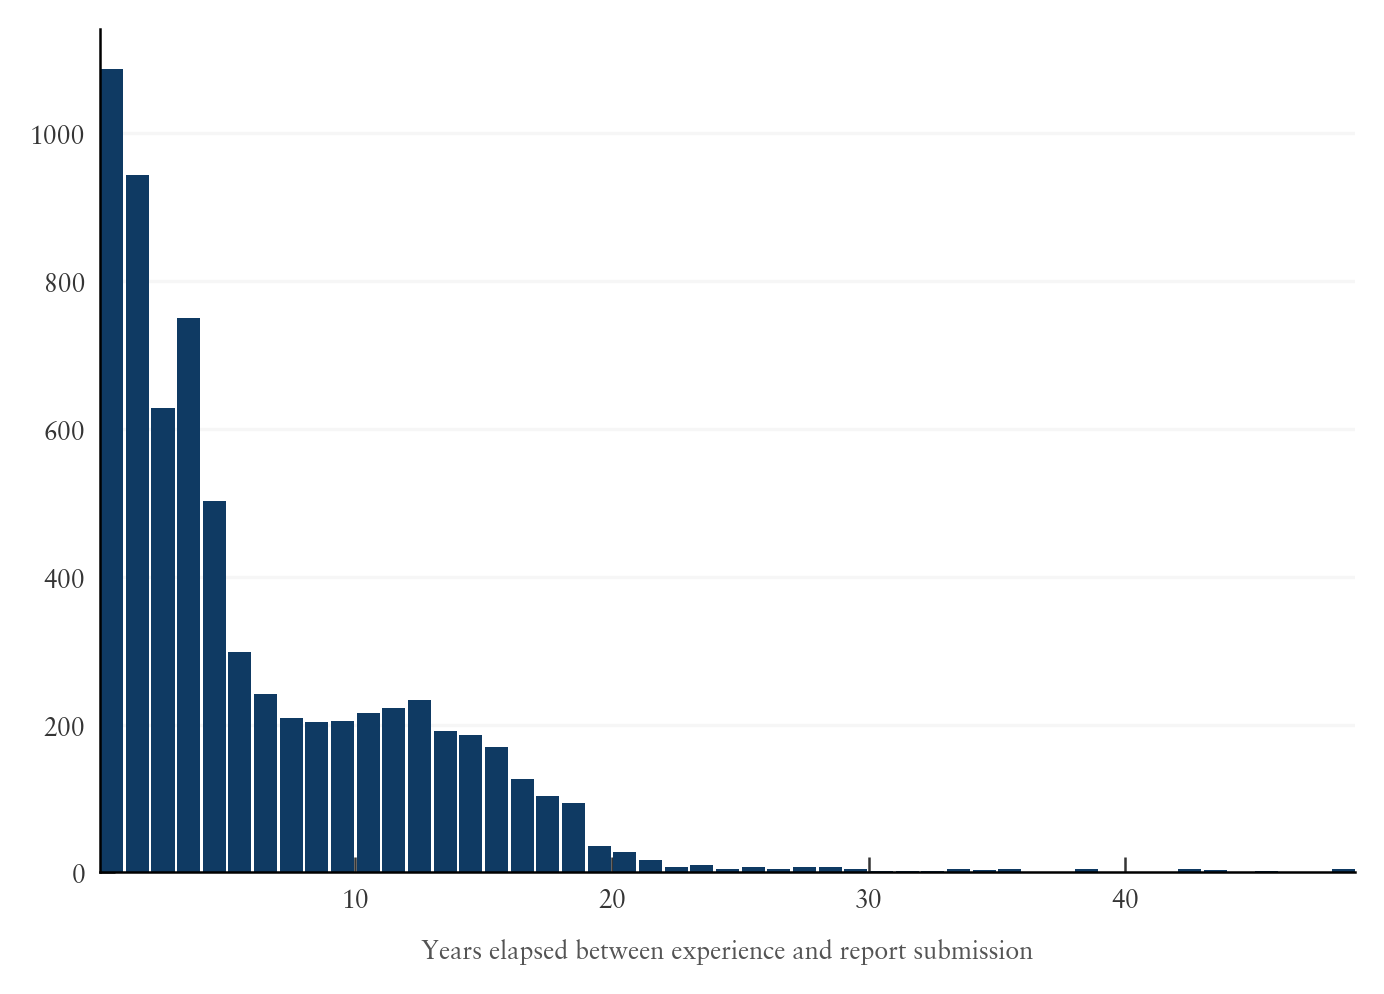

 2% of reports submitted ≥20 years after experience
22% of reports submitted ≥10 years after experience
38% of reports submitted ≥5 years after experience
69% of reports submitted ≥1 years after experience


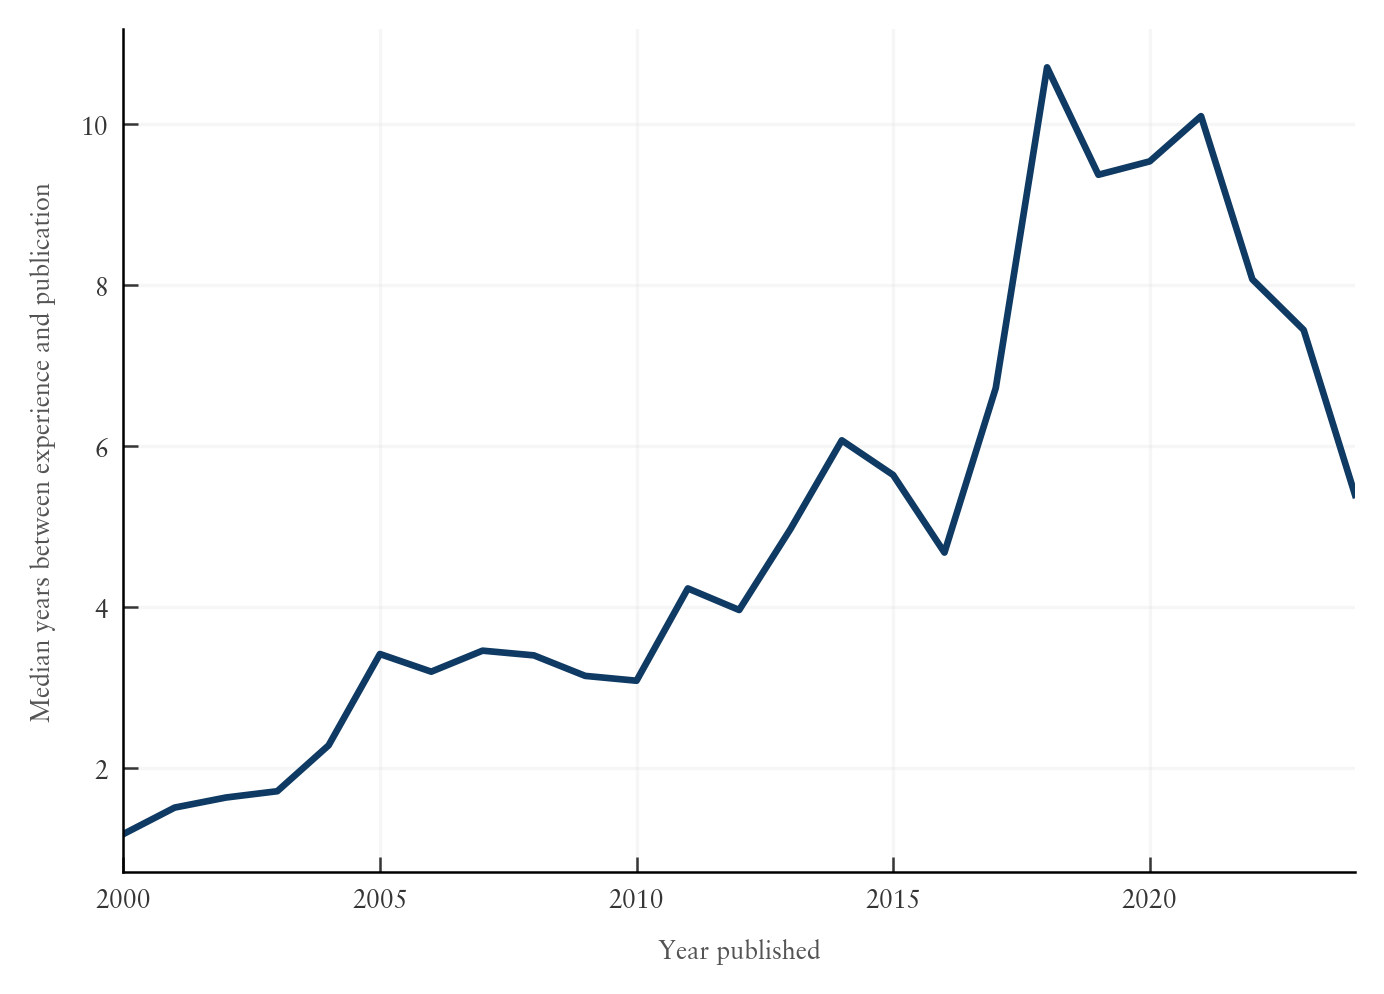

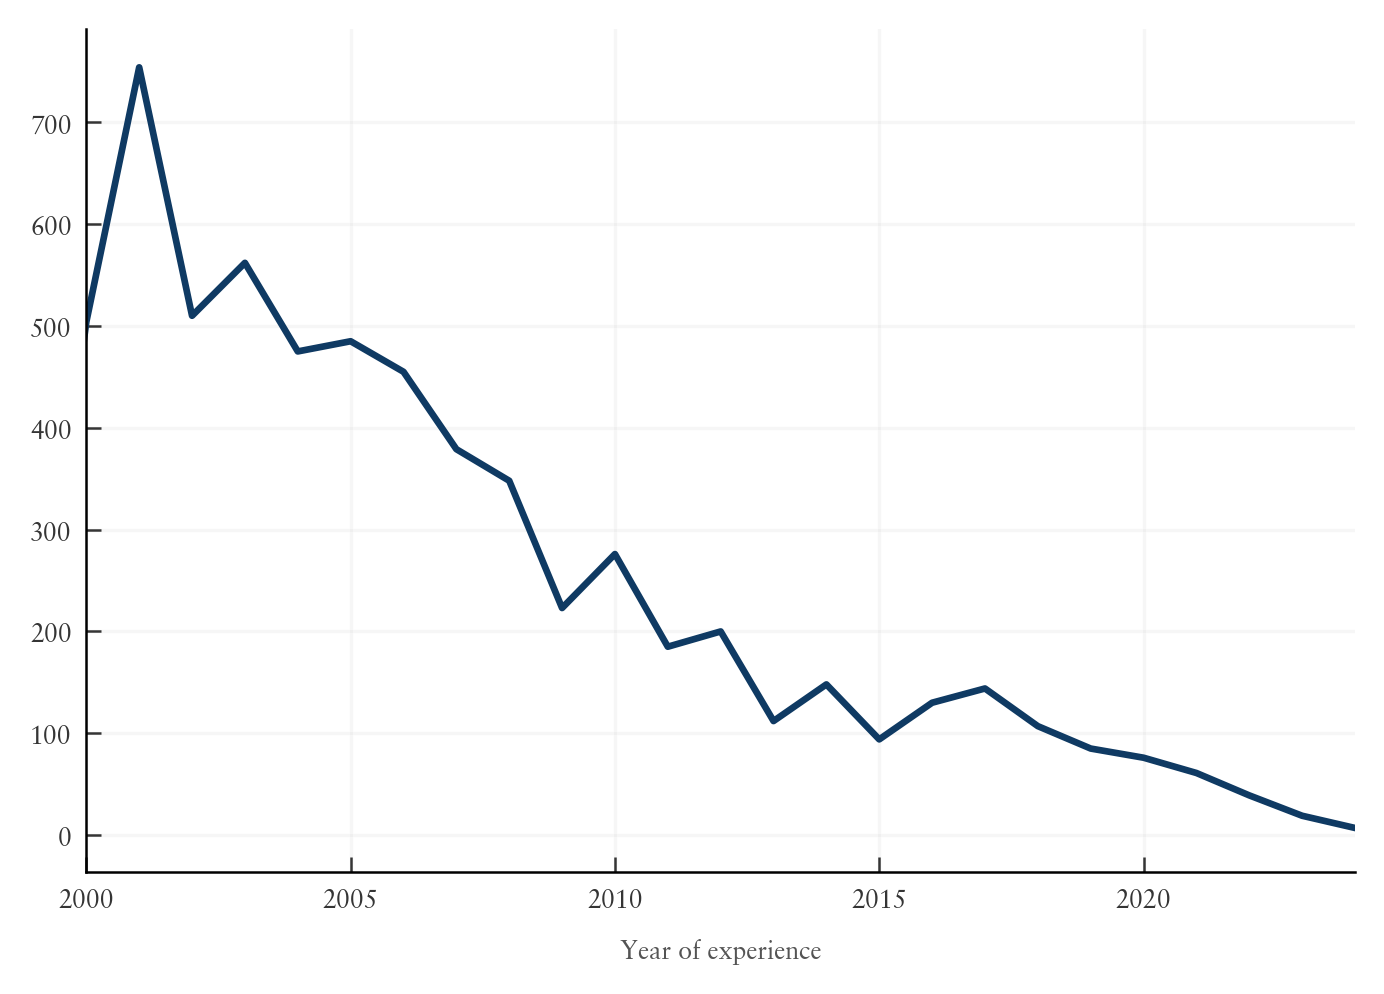

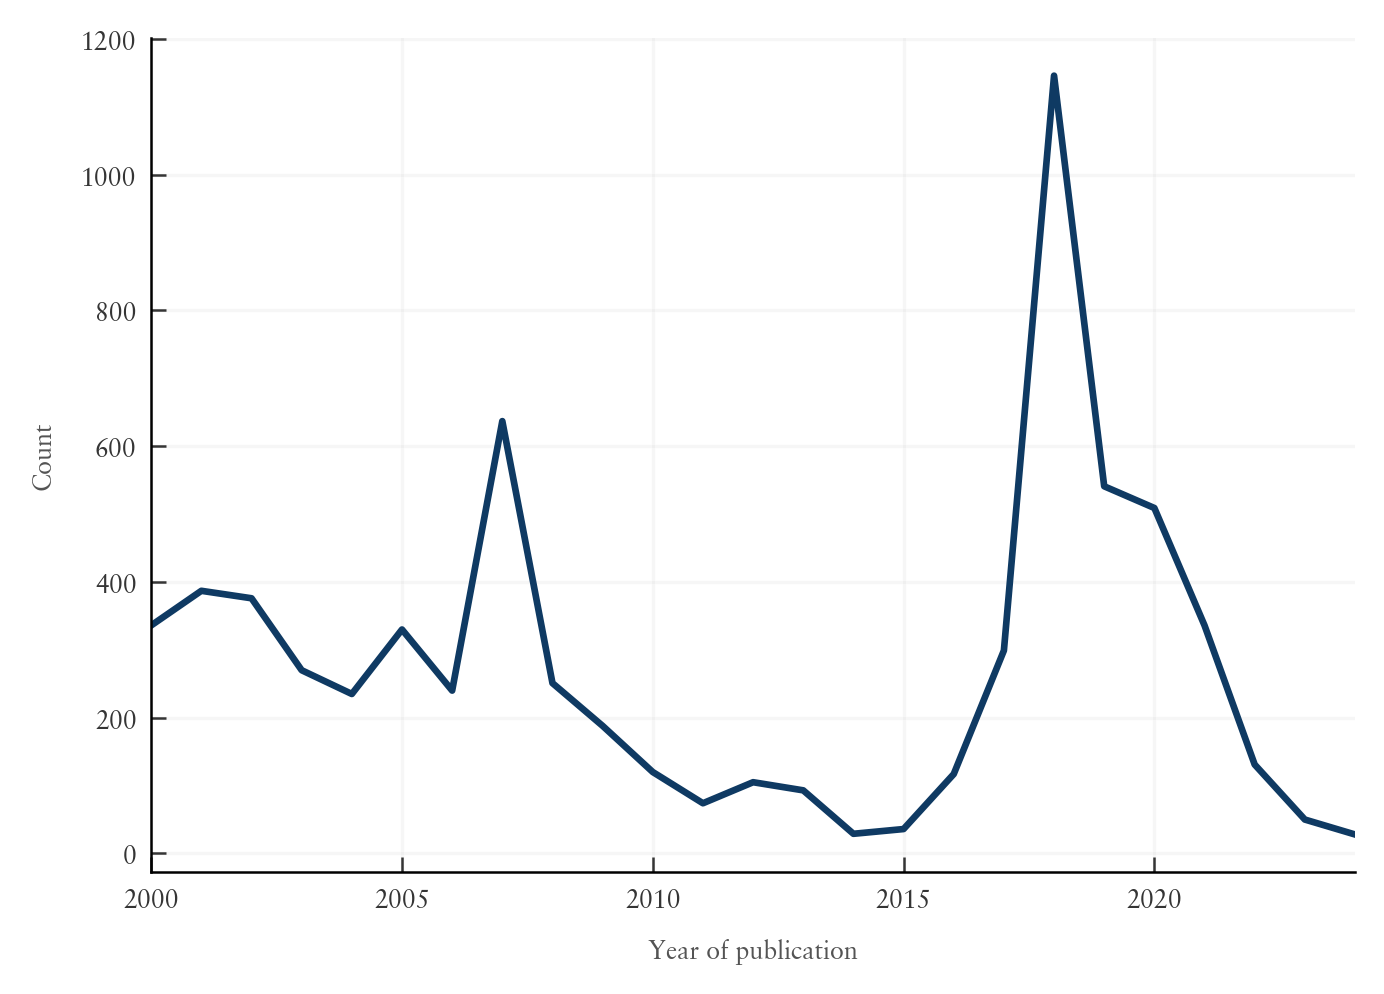

In [11]:
plt.hist(
    database["years_since_experience"],
    bins = range(50),
    rwidth = 0.9,
)
print(f"""{database["years_since_experience"].isna().mean():>3.0%} of reports did not list when the experience took place""")
plt.xlabel("Years elapsed between experience and report submission")
plt.show()
for window in (20, 10, 5, 1):
    print(f"""{(database["years_since_experience"] > window).mean():>3.0%} of reports submitted ≥{window} years after experience""")

plt.figure()
database.groupby(database["submission_timestamp"].dt.year)["years_since_experience"].mean().plot()
plt.xlabel("Year published")
plt.ylabel("Median years between experience and publication")
plt.show()

plt.figure()
database.groupby(database["experience_timestamp"].dt.year).size().plot()
plt.xlabel("Year of experience")
plt.ylabel("")
plt.xlim(2000, 2024)
plt.show()

plt.figure()
database.groupby(database["submission_timestamp"].dt.year).size().plot()
plt.xlabel("Year of publication")
plt.ylabel("Count")
plt.xlim(2000, 2024)
plt.show()